# Phase 1.5 Trace Viewer
Interactive step-by-step inspection of beliefs, EFE, and model slices for one episode.

In [ ]:
# pyright: reportUndefinedVariable=false
import sys
from pathlib import Path

# add repo root to Python path
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

from agent.generative_model import build_phase1_5_model
from agent.pymdp_agent_phase1_5 import ActiveInferenceDisambiguationAgent
from env.objects import WorldObject
from env.world import TwoObjectAffordanceWorld

In [8]:
model = build_phase1_5_model()
trace = []
episode = None

# Retry with different seeds until we get a multi-step trace.
for trial_seed in range(1, 50):
    agent = ActiveInferenceDisambiguationAgent(
        model=build_phase1_5_model(),
        policy_precision=2.0,
        seed=trial_seed,
        stochastic_action=True,
    )
    world = TwoObjectAffordanceWorld(
        object_1=WorldObject(name='object_1', height=1),
        object_2=WorldObject(name='object_2', height=0),
        target_height=1,
    )
    episode = agent.rollout_episode(
        world=world,
        max_steps=10,
        carry_affordance_belief=False,
        enable_trace=True,
    )
    trace = episode['trace']
    if len(trace) > 1:
        break

if len(trace) <= 1:
    raise RuntimeError(
        'Trace has only one step, so the slider cannot move. '
        'Increase max_steps or adjust policy/world setup.'
    )

print(
    f"steps={len(trace)} success={episode['success']} "
    f"steps_to_success={episode['steps_to_success']}"
)


steps=1 success=True steps_to_success=1


IntSlider(value=0, description='step', max=0)

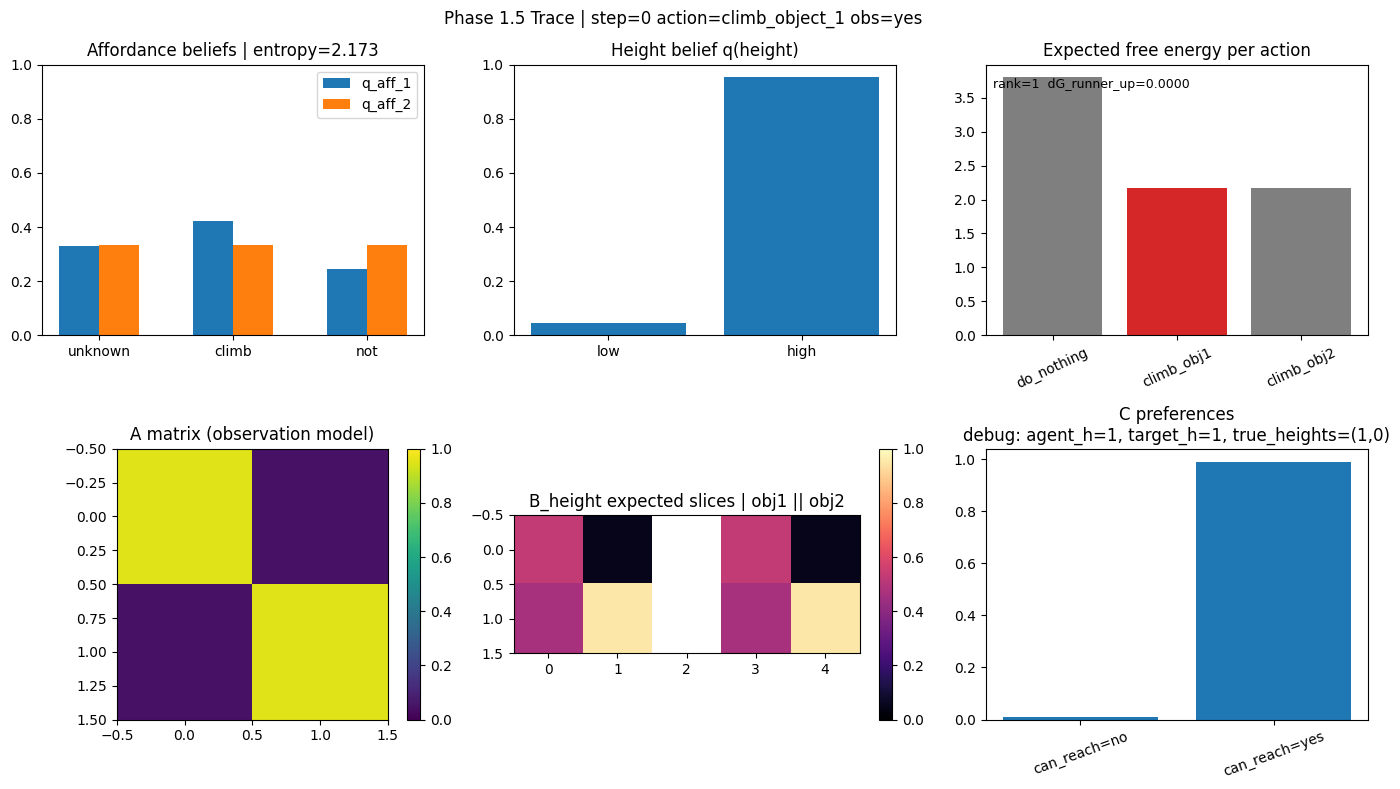

In [9]:
def render_step(i: int):
    print(f'rendering step: {i}')
    tr = trace[i]

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    fig.suptitle(f"Phase 1.5 Trace | step={tr['t']} action={tr['action']} obs={tr['observation']}", fontsize=12)

    ax = axes[0, 0]
    x = np.arange(3)
    ax.bar(x - 0.15, tr['q_aff_1'], width=0.3, label='q_aff_1')
    ax.bar(x + 0.15, tr['q_aff_2'], width=0.3, label='q_aff_2')
    ax.set_xticks(x)
    ax.set_xticklabels(['unknown', 'climb', 'not'])
    ax.set_ylim(0.0, 1.0)
    ax.set_title(f"Affordance beliefs | entropy={tr['entropy_aff_total']:.3f}")
    ax.legend()

    ax = axes[0, 1]
    ax.bar([0, 1], tr['q_height'])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['low', 'high'])
    ax.set_ylim(0.0, 1.0)
    ax.set_title('Height belief q(height)')

    ax = axes[0, 2]
    actions = ['do_nothing', 'climb_obj1', 'climb_obj2']
    g = tr['efe_per_action']
    colors = ['tab:gray', 'tab:gray', 'tab:gray']
    colors[int(tr['chosen_action'])] = 'tab:red'
    ax.bar(actions, g, color=colors)
    ax.set_title('Expected free energy per action')
    ax.text(0.02, 0.95, f"rank={tr['selected_action_rank']}  dG_runner_up={tr['delta_G_to_runner_up']:.4f}",
            transform=ax.transAxes, va='top', fontsize=9)
    ax.tick_params(axis='x', rotation=25)

    ax = axes[1, 0]
    im = ax.imshow(tr['A'], cmap='viridis', vmin=0.0, vmax=1.0)
    ax.set_title('A matrix (observation model)')
    fig.colorbar(im, ax=ax, fraction=0.046)

    ax = axes[1, 1]
    b1 = tr['B_height_relevant']['climb_object_1_expected']
    b2 = tr['B_height_relevant']['climb_object_2_expected']
    stacked = np.hstack([b1, np.full((2, 1), np.nan), b2])
    im2 = ax.imshow(stacked, cmap='magma', vmin=0.0, vmax=1.0)
    ax.set_title('B_height expected slices | obj1 || obj2')
    fig.colorbar(im2, ax=ax, fraction=0.046)

    ax = axes[1, 2]
    ax.bar(['can_reach=no', 'can_reach=yes'], tr['C'])
    dbg = tr['world_info']
    true_h1 = getattr(world, '_object_1').height
    true_h2 = getattr(world, '_object_2').height
    ax.set_title(
        'C preferences\n'
        f"debug: agent_h={dbg.get('agent_height_internal', '?')}, target_h={dbg.get('target_height_internal', '?')}, "
        f"true_heights=({true_h1},{true_h2})"
    )
    ax.tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()

step_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(trace) - 1,
    step=1,
    description='step',
    continuous_update=False,
)
out = widgets.interactive_output(
    render_step,
    {'i': step_slider},
)
display(step_slider, out)